<a href="https://colab.research.google.com/github/Tumars-web/E-commerce-user-growth-analysis/blob/main/notebooks/05_%E7%94%A8%E6%88%B7%E8%BD%AC%E5%8C%96%E6%BC%8F%E6%96%97%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import zipfile
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns


url = 'https://github.com/Tumars-web/E-commerce-user-growth-analysis/raw/main/cleaned_data.csv.zip'
zip_path = 'cleaned_data.zip'

# 下载压缩包
urllib.request.urlretrieve(url, zip_path)

# 解压缩
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# 读取 CSV
df = pd.read_csv('cleaned_data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("数据加载成功！")
df.head()

数据加载成功！


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [12]:
# 获取每位用户的下单次数
user_order_counts = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
user_order_counts.columns = ['CustomerID', 'OrderCount']

# 定义 Activated 和 RepeatPurchase 两类
activated_users = user_order_counts[user_order_counts['OrderCount'] >= 1]['CustomerID'].nunique()
repeat_users = user_order_counts[user_order_counts['OrderCount'] >= 2]['CustomerID'].nunique()

# 构建漏斗表
funnel = pd.DataFrame({
    'Stage': ['Activated Users', 'Repeat Purchasers'],
    'Users': [activated_users, repeat_users]
})
funnel['ConversionRate'] = funnel['Users'] / activated_users


/tmp/ipython-input-14-2437127366.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funnel, x='Stage', y='Users', palette='Blues_d')


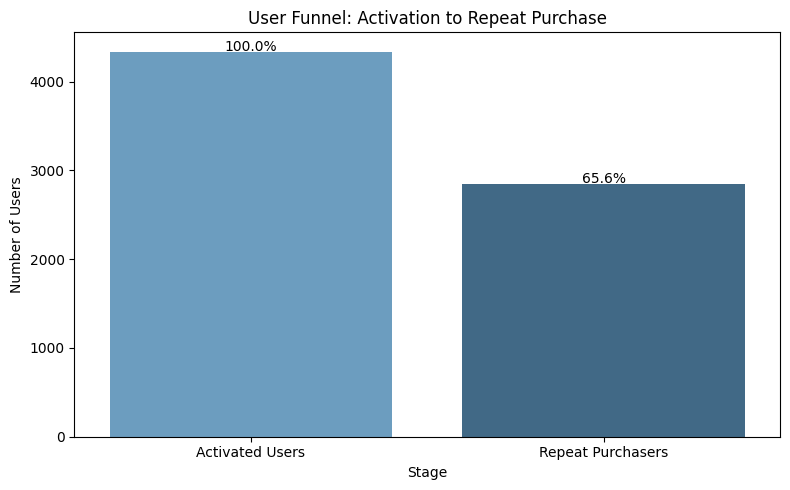

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=funnel, x='Stage', y='Users', palette='Blues_d')

for i, row in funnel.iterrows():
    plt.text(i, row['Users'] + 10, f"{row['ConversionRate']:.1%}", ha='center')

plt.title('User Funnel: Activation to Repeat Purchase')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()


In [15]:
#首单后，用户7日内复购率
#获取每位用户的所有下单日期

# 按用户排序订单时间
df_sorted = df.sort_values(by=['CustomerID', 'InvoiceDate'])

# 每位用户的订单时间列表
user_orders = df_sorted.groupby('CustomerID')['InvoiceDate'].apply(list).reset_index()


In [35]:
def days_between_first_and_second(order_dates):
    if len(order_dates) < 2:
        return None  # 没有第二单
    return (order_dates[1] - order_dates[0]).days

user_orders['DaysTo2ndOrder'] = user_orders['InvoiceDate'].apply(days_between_first_and_second)


In [27]:
# 过滤出完成复购的用户
repeat_users = user_orders['DaysTo2ndOrder'].notna().sum()

# 其中首单后7天内复购的用户
repurchase_within_7 = (user_orders['DaysTo2ndOrder'] <= 7).sum()

# 计算比例
repurchase_7d_rate = repurchase_within_7 / repeat_users

print(f"🔁 首单后 7 天内复购率：{repurchase_7d_rate:.2%}")


🔁 首单后 7 天内复购率：98.34%


In [32]:
# 总新用户数 = 每个用户的首次出现
total_new_users = df['CustomerID'].nunique()

# 激活率 = 激活用户数 / 所有用户
activation_rate = users_reordered_within_7d / total_new_users
print(f"⚡ 用户激活率（7 日内复购）：{activation_rate:.2%}")


⚡ 用户激活率（7 日内复购）：96.73%


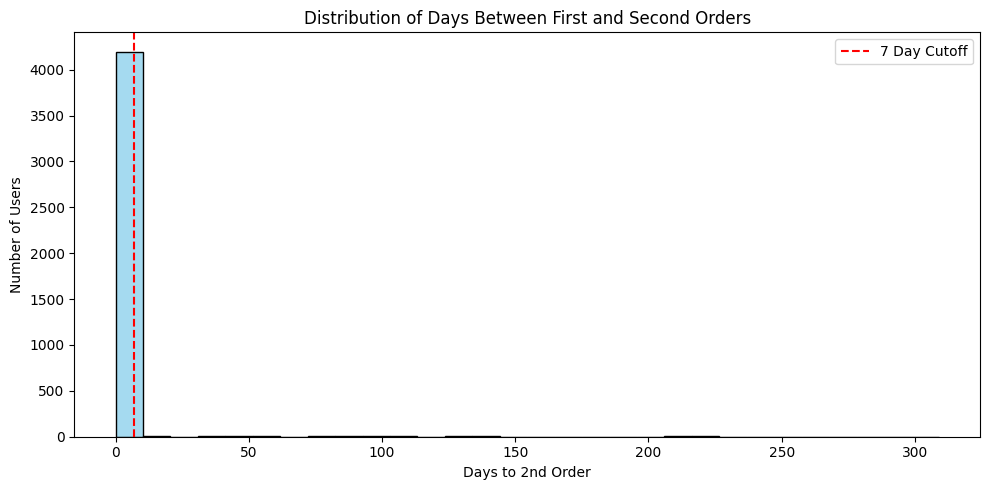

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(user_orders['DaysTo2ndOrder'].dropna(), bins=30, kde=False, color='skyblue')
plt.axvline(7, color='red', linestyle='--', label='7 Day Cutoff')
plt.title('Distribution of Days Between First and Second Orders')
plt.xlabel('Days to 2nd Order')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.show()


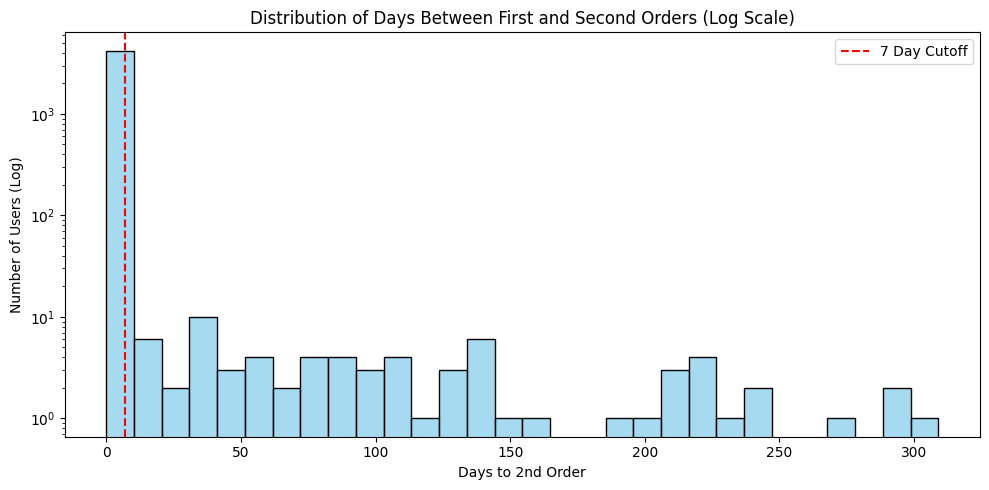

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(user_orders['DaysTo2ndOrder'].dropna(), bins=30, color='skyblue')
plt.axvline(7, color='red', linestyle='--', label='7 Day Cutoff')
plt.yscale('log')  # 👈 关键：对数尺度
plt.title('Distribution of Days Between First and Second Orders (Log Scale)')
plt.xlabel('Days to 2nd Order')
plt.ylabel('Number of Users (Log)')
plt.legend()
plt.tight_layout()
plt.show()
